In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

In [2]:
# 目标函数是 y = x，在此打印出目标函数来作为参考，即使神经网络想要学习到函数
x_func = np.linspace(-4,4,100)
y_func = x_func

x_low_var = np.random.uniform(-3, -2, 100)
y_low_var = (x_low_var + 
                np.random.randn(*x_low_var.shape)*0.5 )

# 左边部分方差比较小，加上噪音来了解数据的不确定性
x_high_var = np.random.uniform(2, 3, 100)
y_high_var = (x_high_var + 
                 np.random.randn(*x_high_var.shape) * 0.1)

# 右边部分方差比较大
x_train = np.concatenate([x_low_var, x_high_var])
y_train = np.concatenate([y_low_var, y_high_var])

x_test = np.linspace(-10,10,100)
y_test = x_test

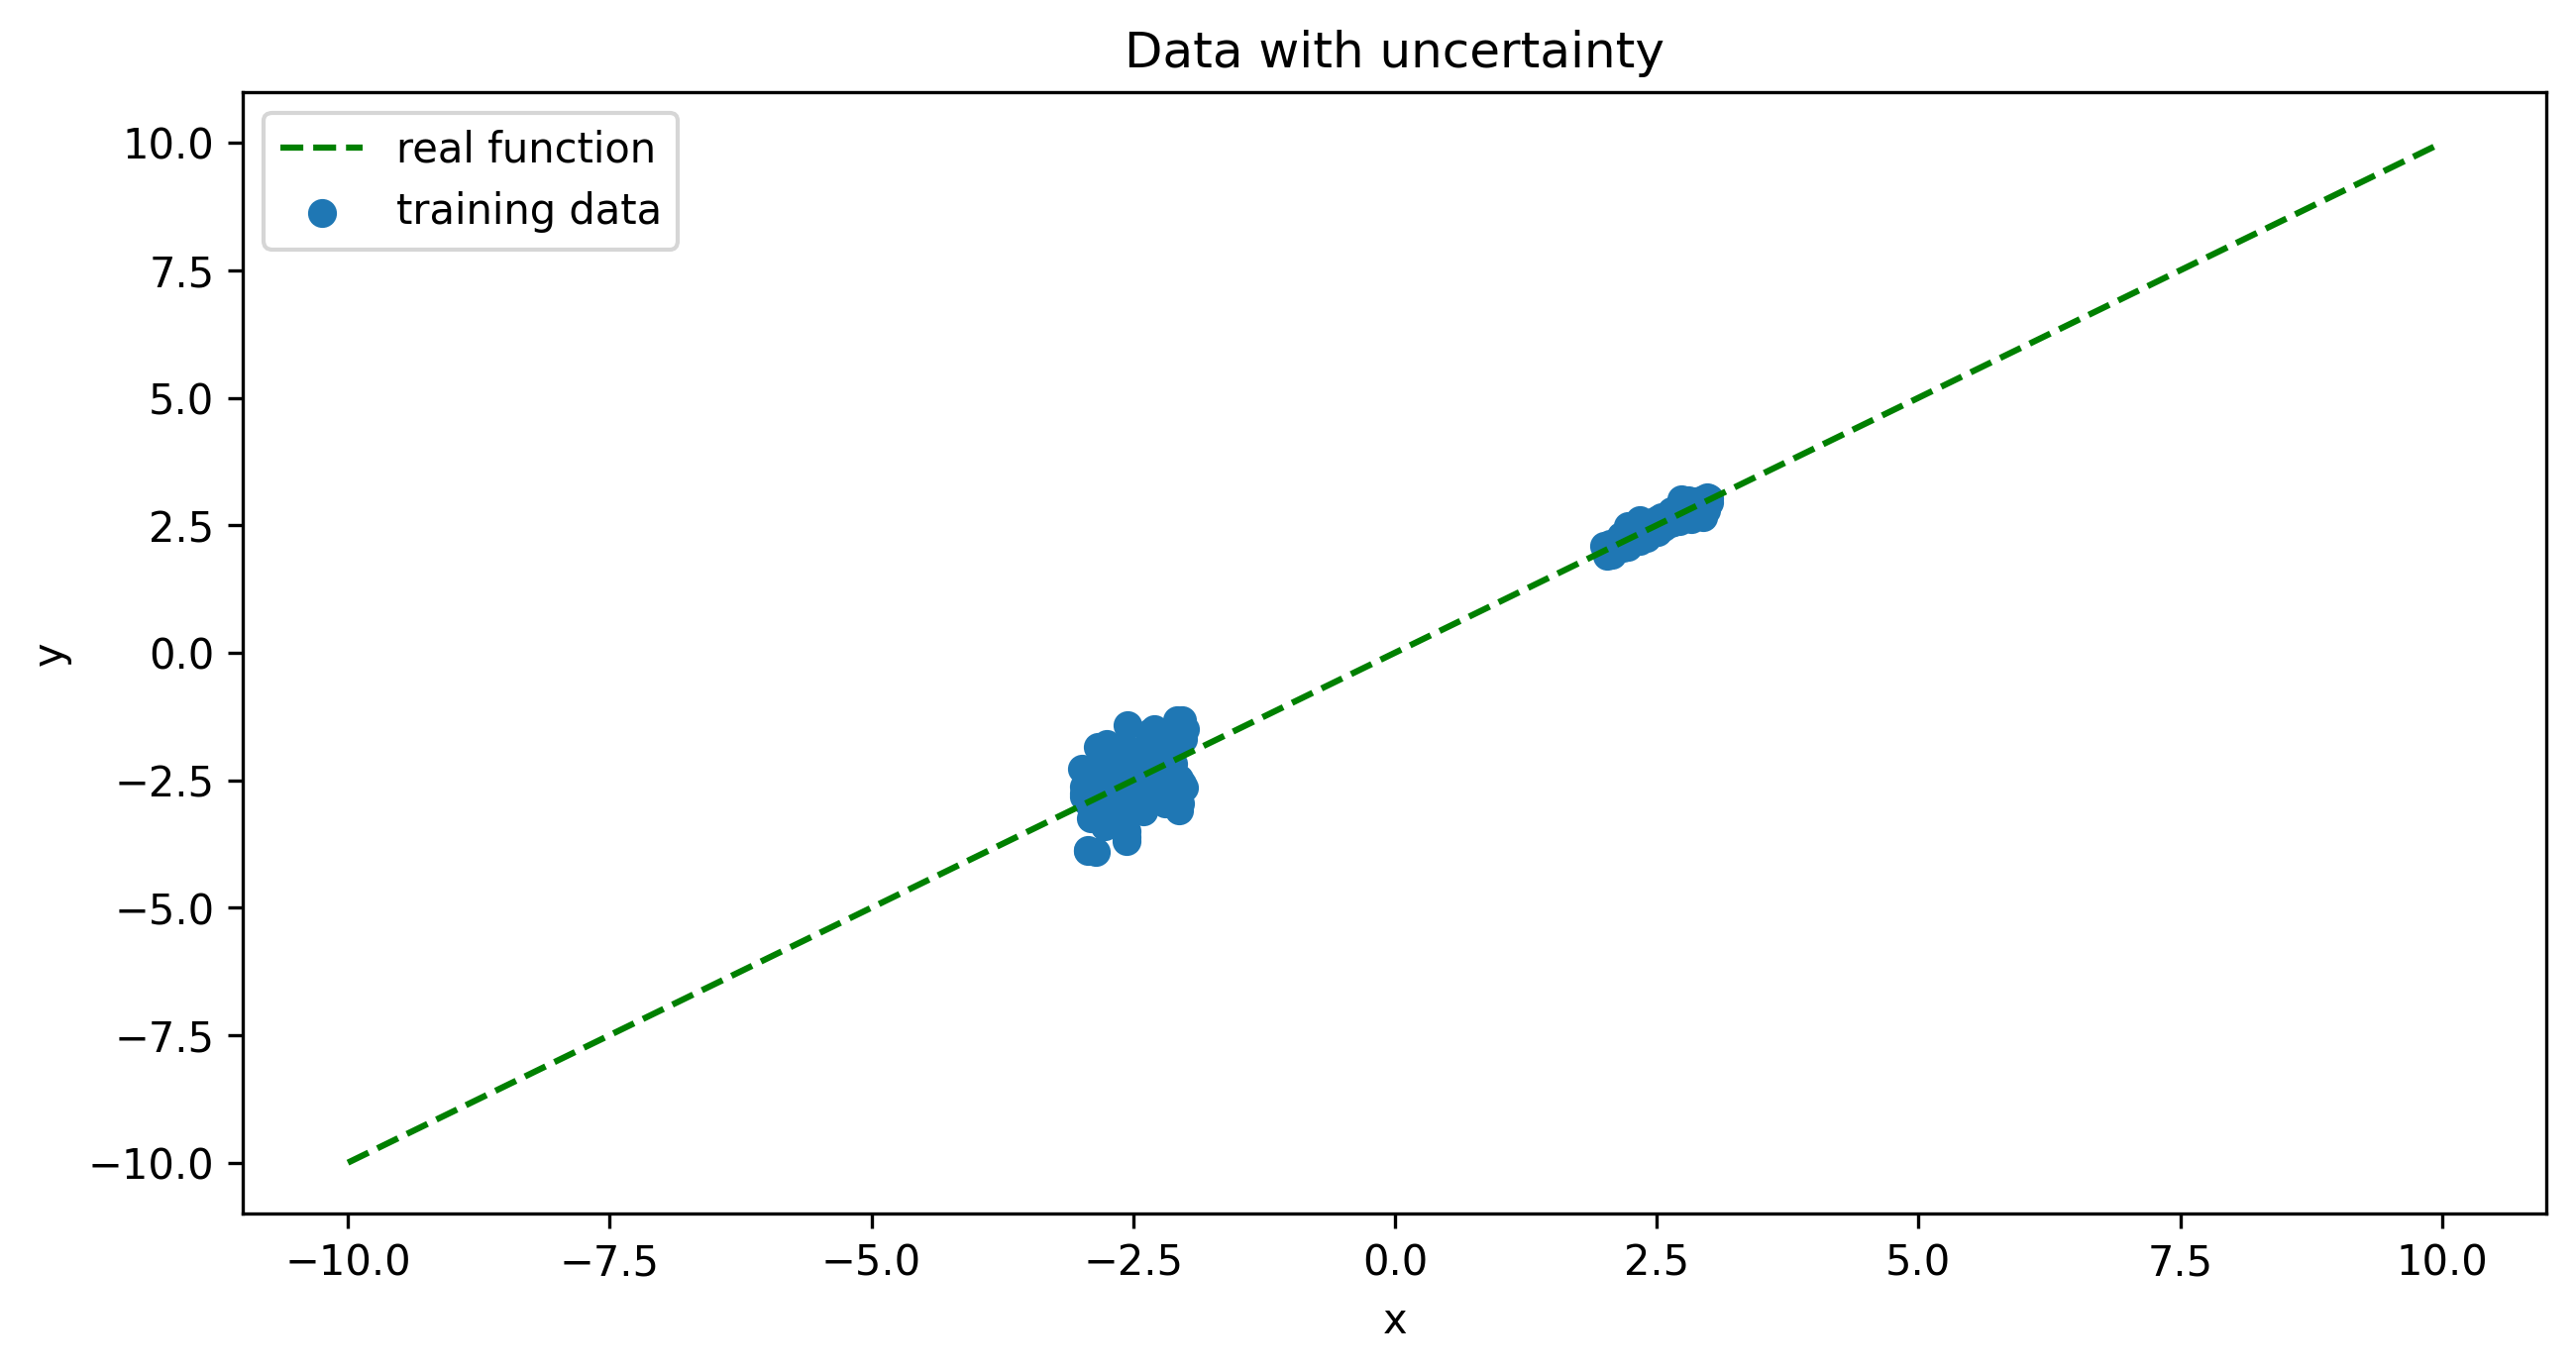

In [3]:
def visual_dataset(x_train, y_train, x_test, y_test):
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    ax.scatter(x_train, y_train, label='training data')
    ax.plot(x_test, y_test, ls='--', label='real function', 
            color='green')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.set_title('Data with uncertainty');

visual_dataset(x_train, y_train, x_test, y_test)

In [4]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, 
                 layers=[5, 10, 20, 10, 5], 
                 dropout=0.3,
                 loss="MSE",
                 Relu=False):
        super(Net, self).__init__()
        self.loss = loss
        self.output_dim = output_dim

        # 输入层
        self.input_layer = nn.Linear(input_dim, layers[0])
        
        # 隐藏层
        hidden_layers = []
        prev_layer = layers[0]
        for layer in layers[1:]:
            hidden_layers.append(nn.Linear(prev_layer, layer ))
            if dropout != 0:
                hidden_layers.append(nn.Dropout(p = dropout))
            
            if Relu:
                hidden_layers.append(nn.ReLU())
            prev_layer = layer
        self.hidden_layers = nn.Sequential(*hidden_layers)

        # 输出层
        self.output_layer = nn.Linear(layers[-1], output_dim)
        
        # loss function
        self.loss_function = self.create_loss()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

    def create_loss(self):
        if self.loss == 'MSE' and self.output_dim == 1:
            return torch.nn.MSELoss()

net = Net()
print(net)

Net(
  (input_layer): Linear(in_features=1, out_features=5, bias=True)
  (hidden_layers): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): Dropout(p=0.3, inplace=False)
  )
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
  (loss_function): MSELoss()
)


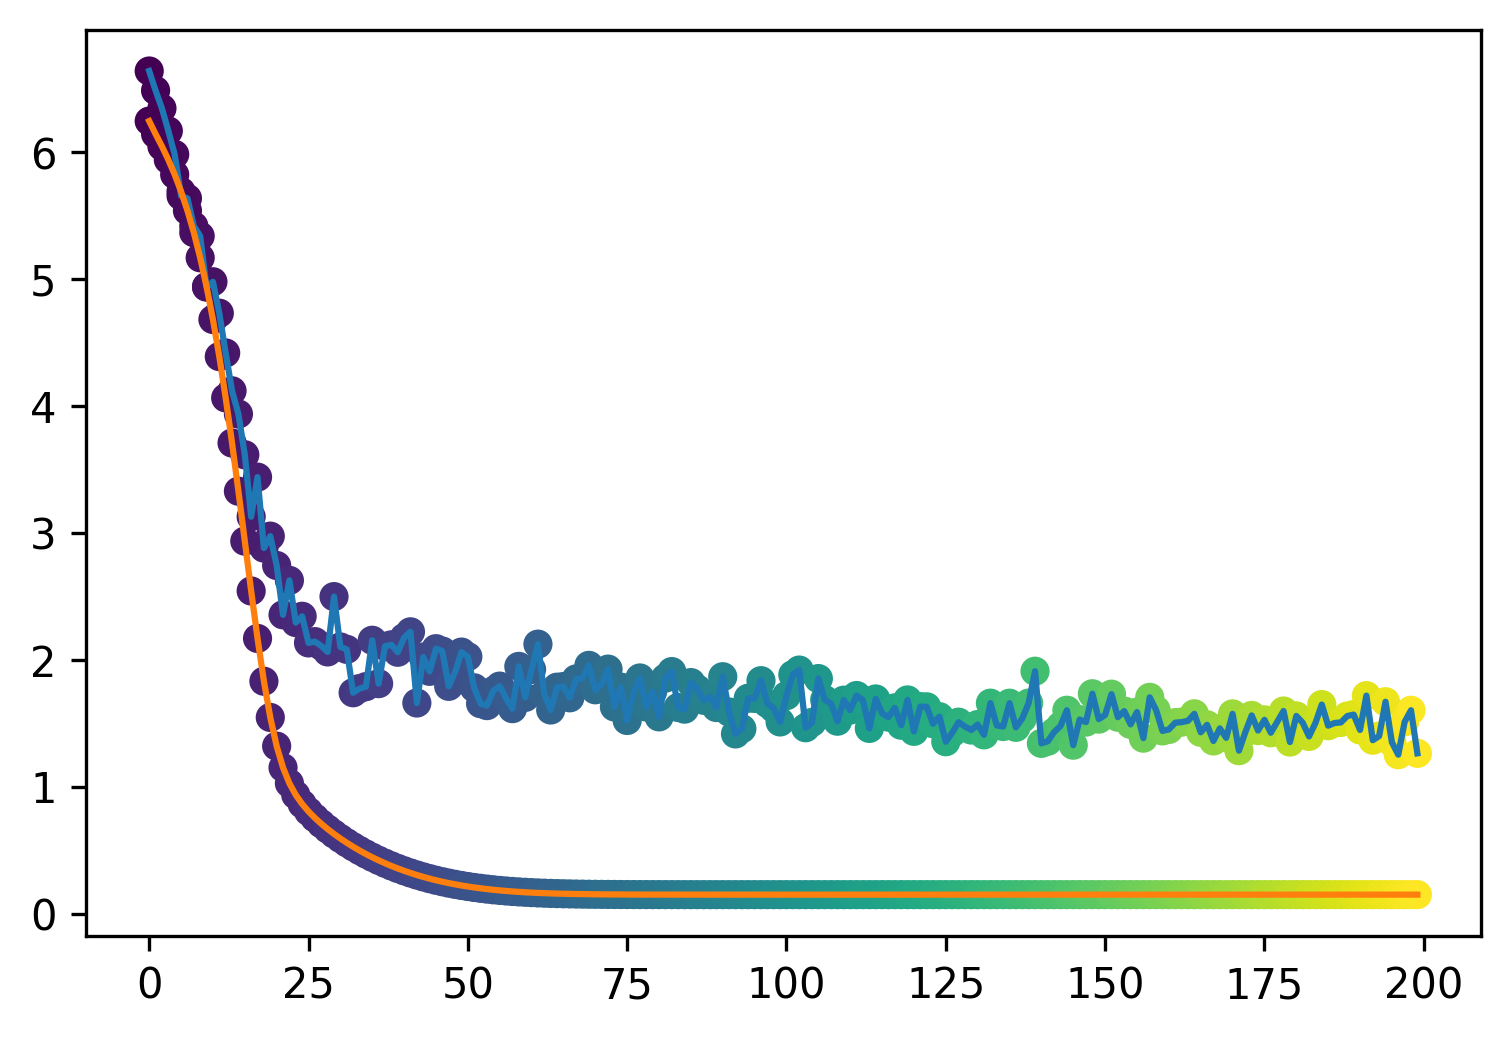

In [101]:
def train(model, data, batch_size=8,  epochs=100, lr = 0.0001, show=True):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    x_train, y_train = data
    
    # 将数据转换成兼容的数据格式
    x_train = torch.tensor(x_train.astype('float32'))
    y_train = torch.tensor(y_train.astype('float32'))
    
    log_step = []
    log_loss = []
    for epoch in range(epochs):
        epoch_loss = 0
        for start_index in range(0, len(x_train), batch_size):
            x = x_train[start_index: start_index+batch_size].reshape(-1, 1)
            y = y_train[start_index: start_index+batch_size].reshape(-1, 1)
            
            pred = model(x)            
            loss = model.loss_function(pred, y)
            
            epoch_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # 计算一个epoch的总的loss值
        avg_loss = epoch_loss/(len(x_train)//batch_size)
        log_step.append(epoch)
        log_loss.append(avg_loss)

    # 对训练过程的loss值进行监控    
    if show:    
        plt.scatter(log_step, log_loss, c=log_step)
        plt.plot(log_step, log_loss)

    return model

model_with_dropout = train(Net(dropout=0.3, Relu=False), data=(x_train, y_train), epochs=200)
model_without_dropout = train(Net(dropout=0, Relu=False), data=(x_train, y_train), epochs=200)

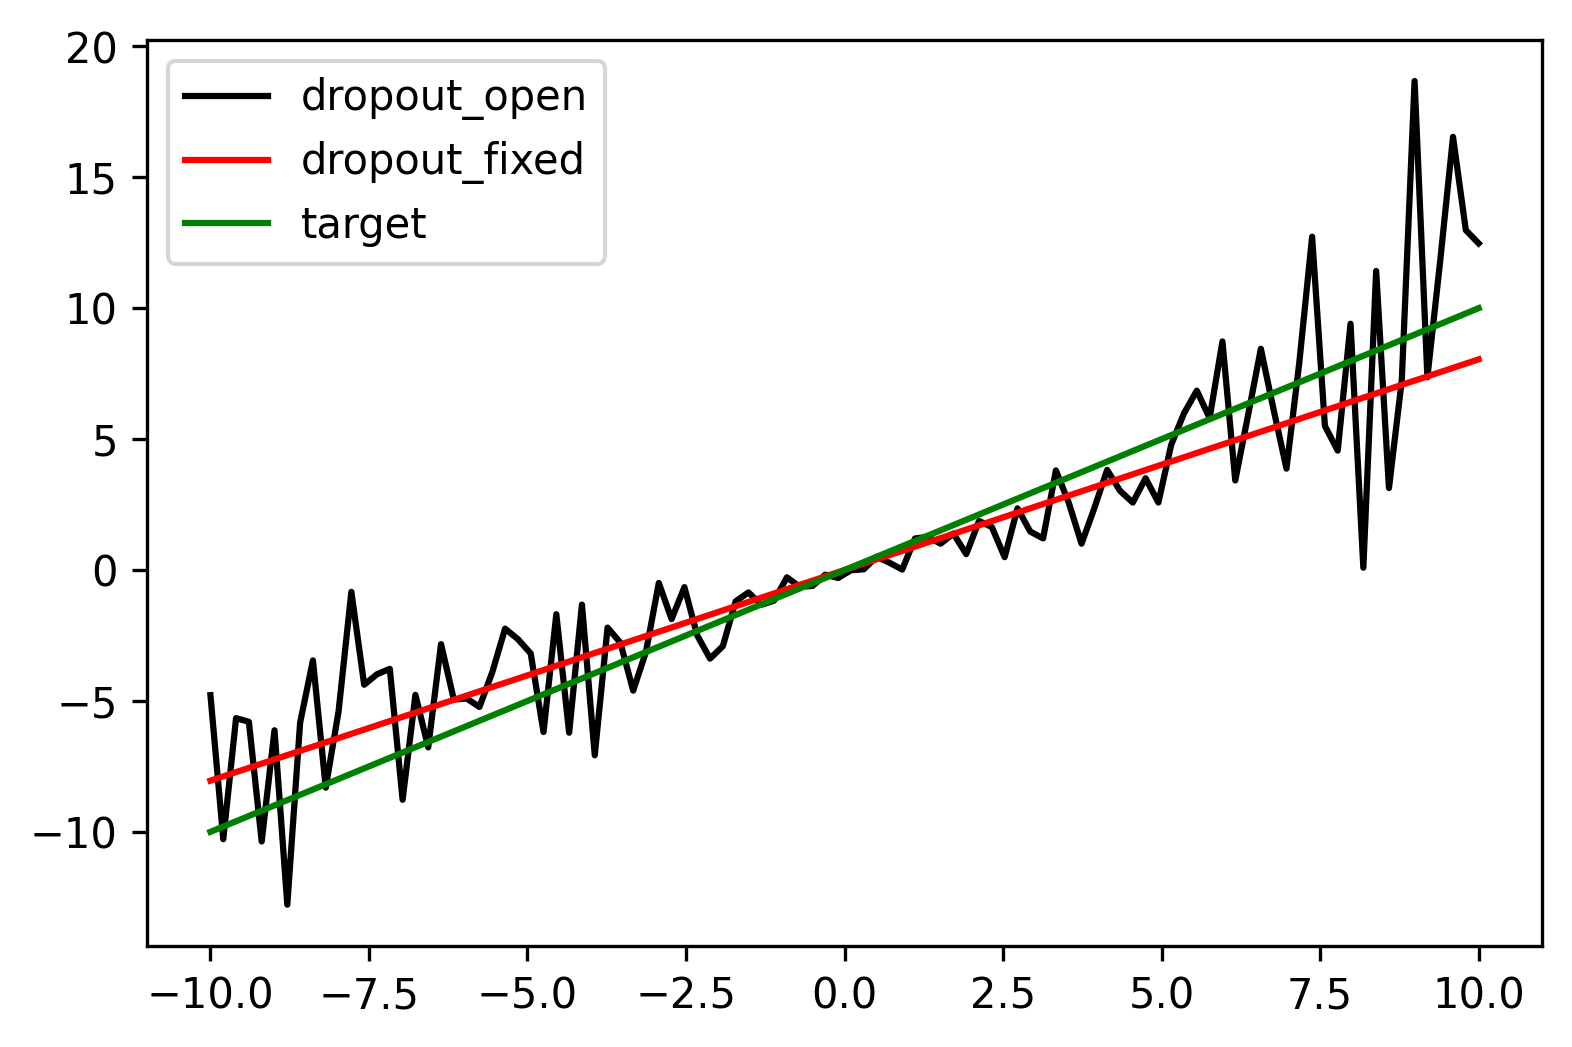

In [104]:
def test(model, test_data, fixed):
    if fixed:
        model.eval()
    else:
        model.train()
    
    # 将数据转换成兼容的数据格式
    test_data = torch.tensor(test_data.astype('float32'))
    test_data = test_data.reshape(-1, 1)
    
    predictions = model(test_data)
    return predictions.detach().numpy()

dropout_pred = test(model_with_dropout, x_test, fixed=False).reshape(-1)
fixed_pred = test(model_with_dropout, x_test, fixed=True).reshape(-1)
plt.plot(x_test, dropout_pred, c='black', label="dropout_open")
plt.plot(x_test, fixed_pred, c='r', label="dropout_fixed")
plt.plot(x_test, y_test, c='g', label="target")
plt.legend()
plt.show()

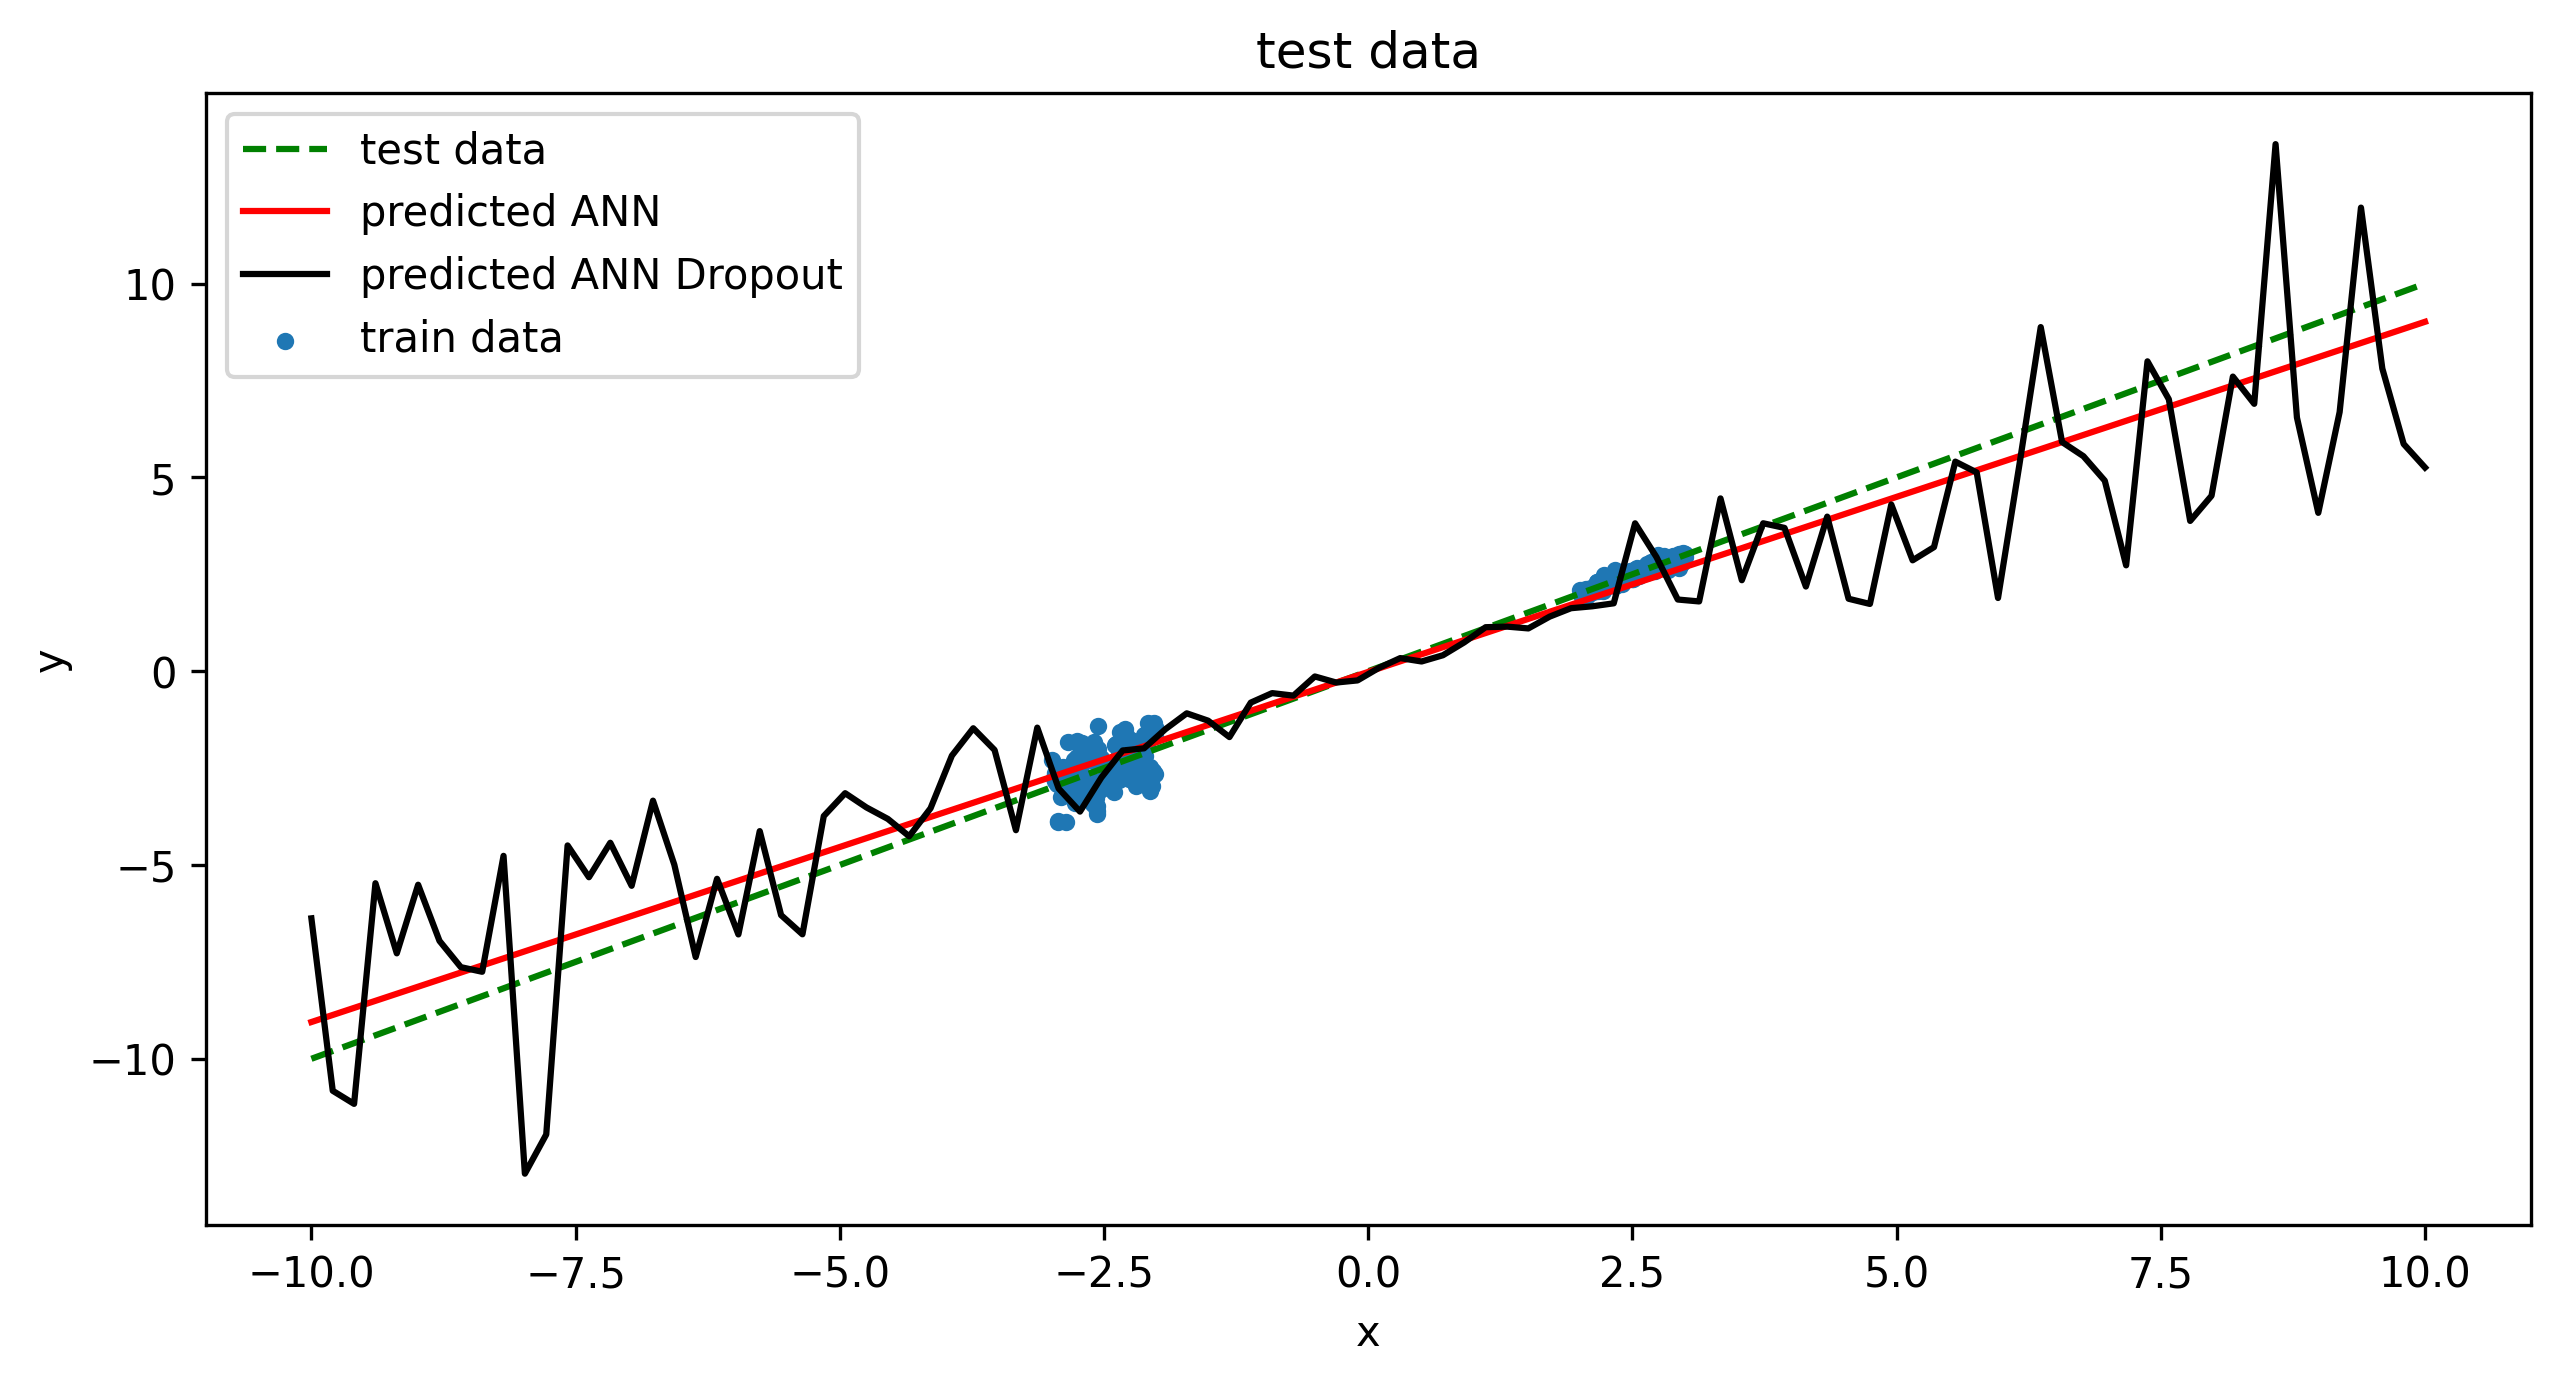

In [34]:
# prediction
pred_dropout = test(model_with_dropout, x_test, False)
pred_fixed = test(model_with_dropout, x_test, True)

# plotting
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(x_train, y_train, s=10, label='train data')
ax.plot(x_test, x_test, ls='--', label='test data', color='green')
ax.plot(x_test, pred_fixed, label='predicted ANN', color='red')
ax.plot(x_test, pred_dropout, label='predicted ANN Dropout', color='black')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_title('test data');

主要参考：

https://towardsdatascience.com/my-deep-learning-model-says-sorry-i-dont-know-the-answer-that-s-absolutely-ok-50ffa562cb0b

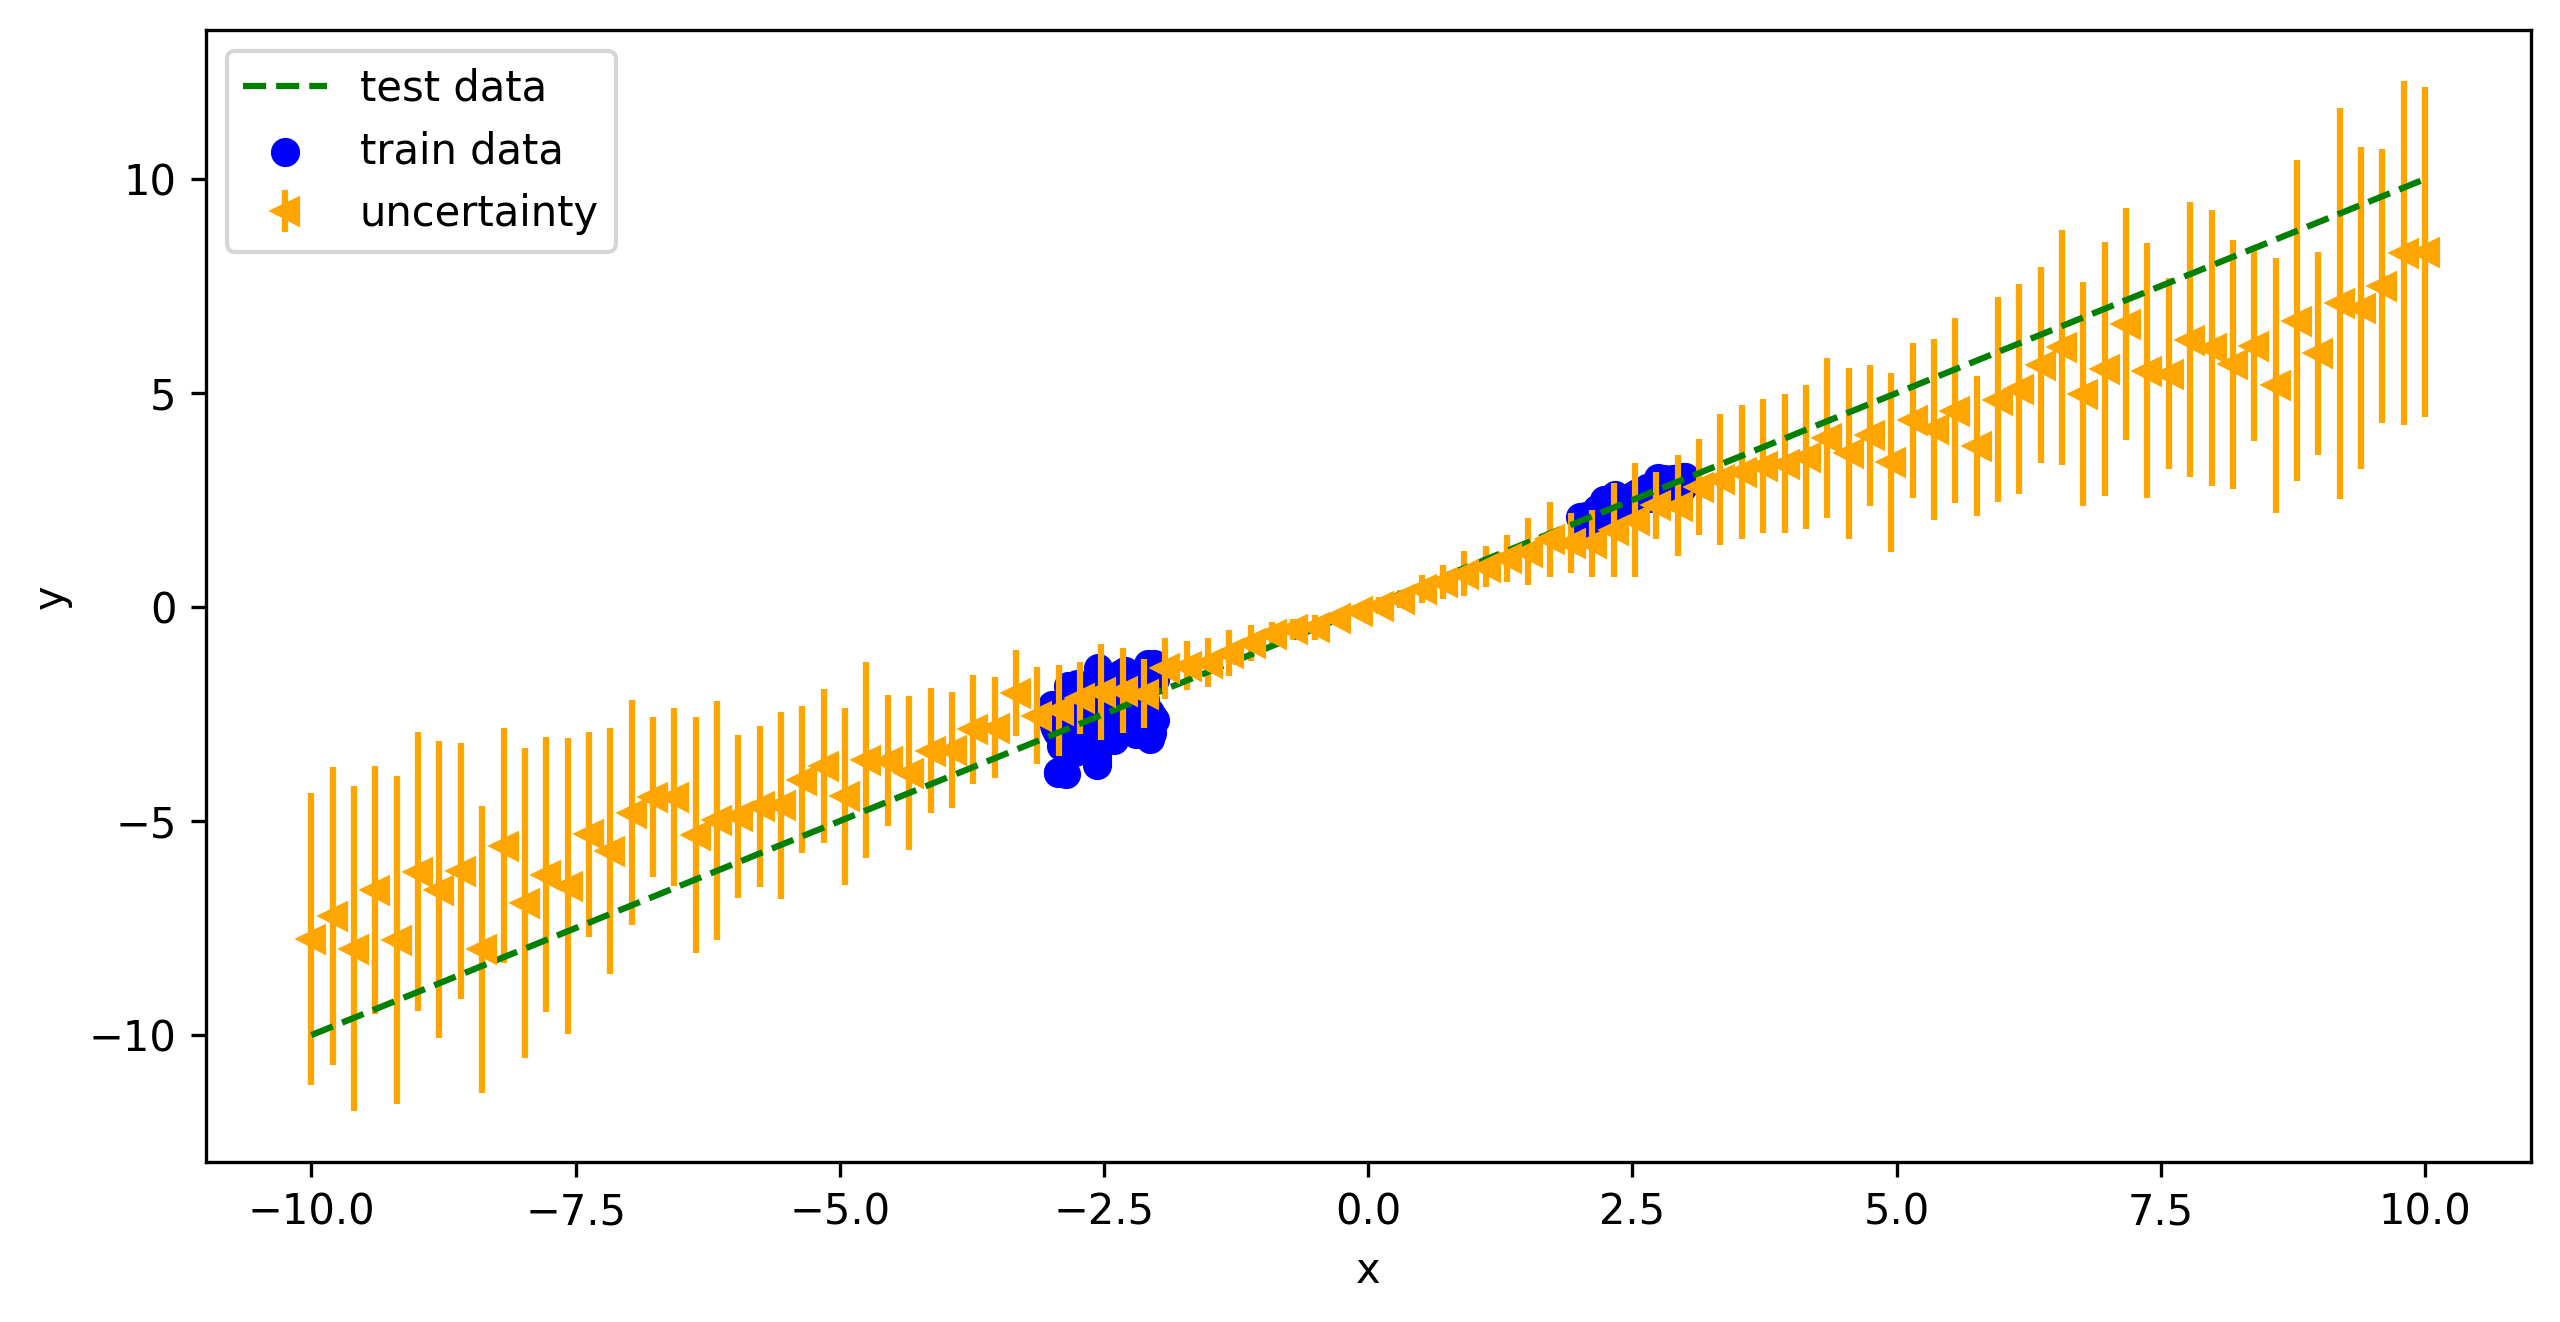

In [105]:
def epistemic_uncertainty(model, test_data, times=30):
    # 确保dropout是打开的，处于inference状态的，而不是处于求平均值的状态
    model.train()
    
    # 将数据转换成兼容的数据格式
    test_input = test_data[0]
    test_gt = test_data[1]
    test_input = torch.tensor(test_input.astype('float32'))
    test_input = test_input.reshape(-1, 1)
    
    predictions = []
    for _ in range(times):
        prediction = model(test_input).reshape(-1)
        predictions.append(prediction.detach().numpy())
        
    predictions = np.array(predictions)
    mean = np.mean(predictions, axis=0)
    std  = np.std(predictions, axis=0)
    return mean, std

def show_uncertainty(train_data, test_data, test_result, function):
    x_train, y_train = train_data
    x_test, y_test = test_data
    mean, std = test_result
    x, y = function
    
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    ax.plot(x_test, y_test, ls='--', color='green', label='test data')
    ax.scatter(x_train, y_train, color='blue', label='train data')
    #ax.plot(x_test, pred_fixed, label='fixed dropout', color='red')
    ax.errorbar(x_test, mean, yerr=std, fmt='<', color='orange', label='uncertainty')
        
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    plt.show()
            

mean, std = epistemic_uncertainty(model_with_dropout, (x_test, y_test) )
show_uncertainty(train_data=(x_train, y_train), test_data=(x_test, y_test), 
                           test_result=(mean, std), function=(x_func, y_func))

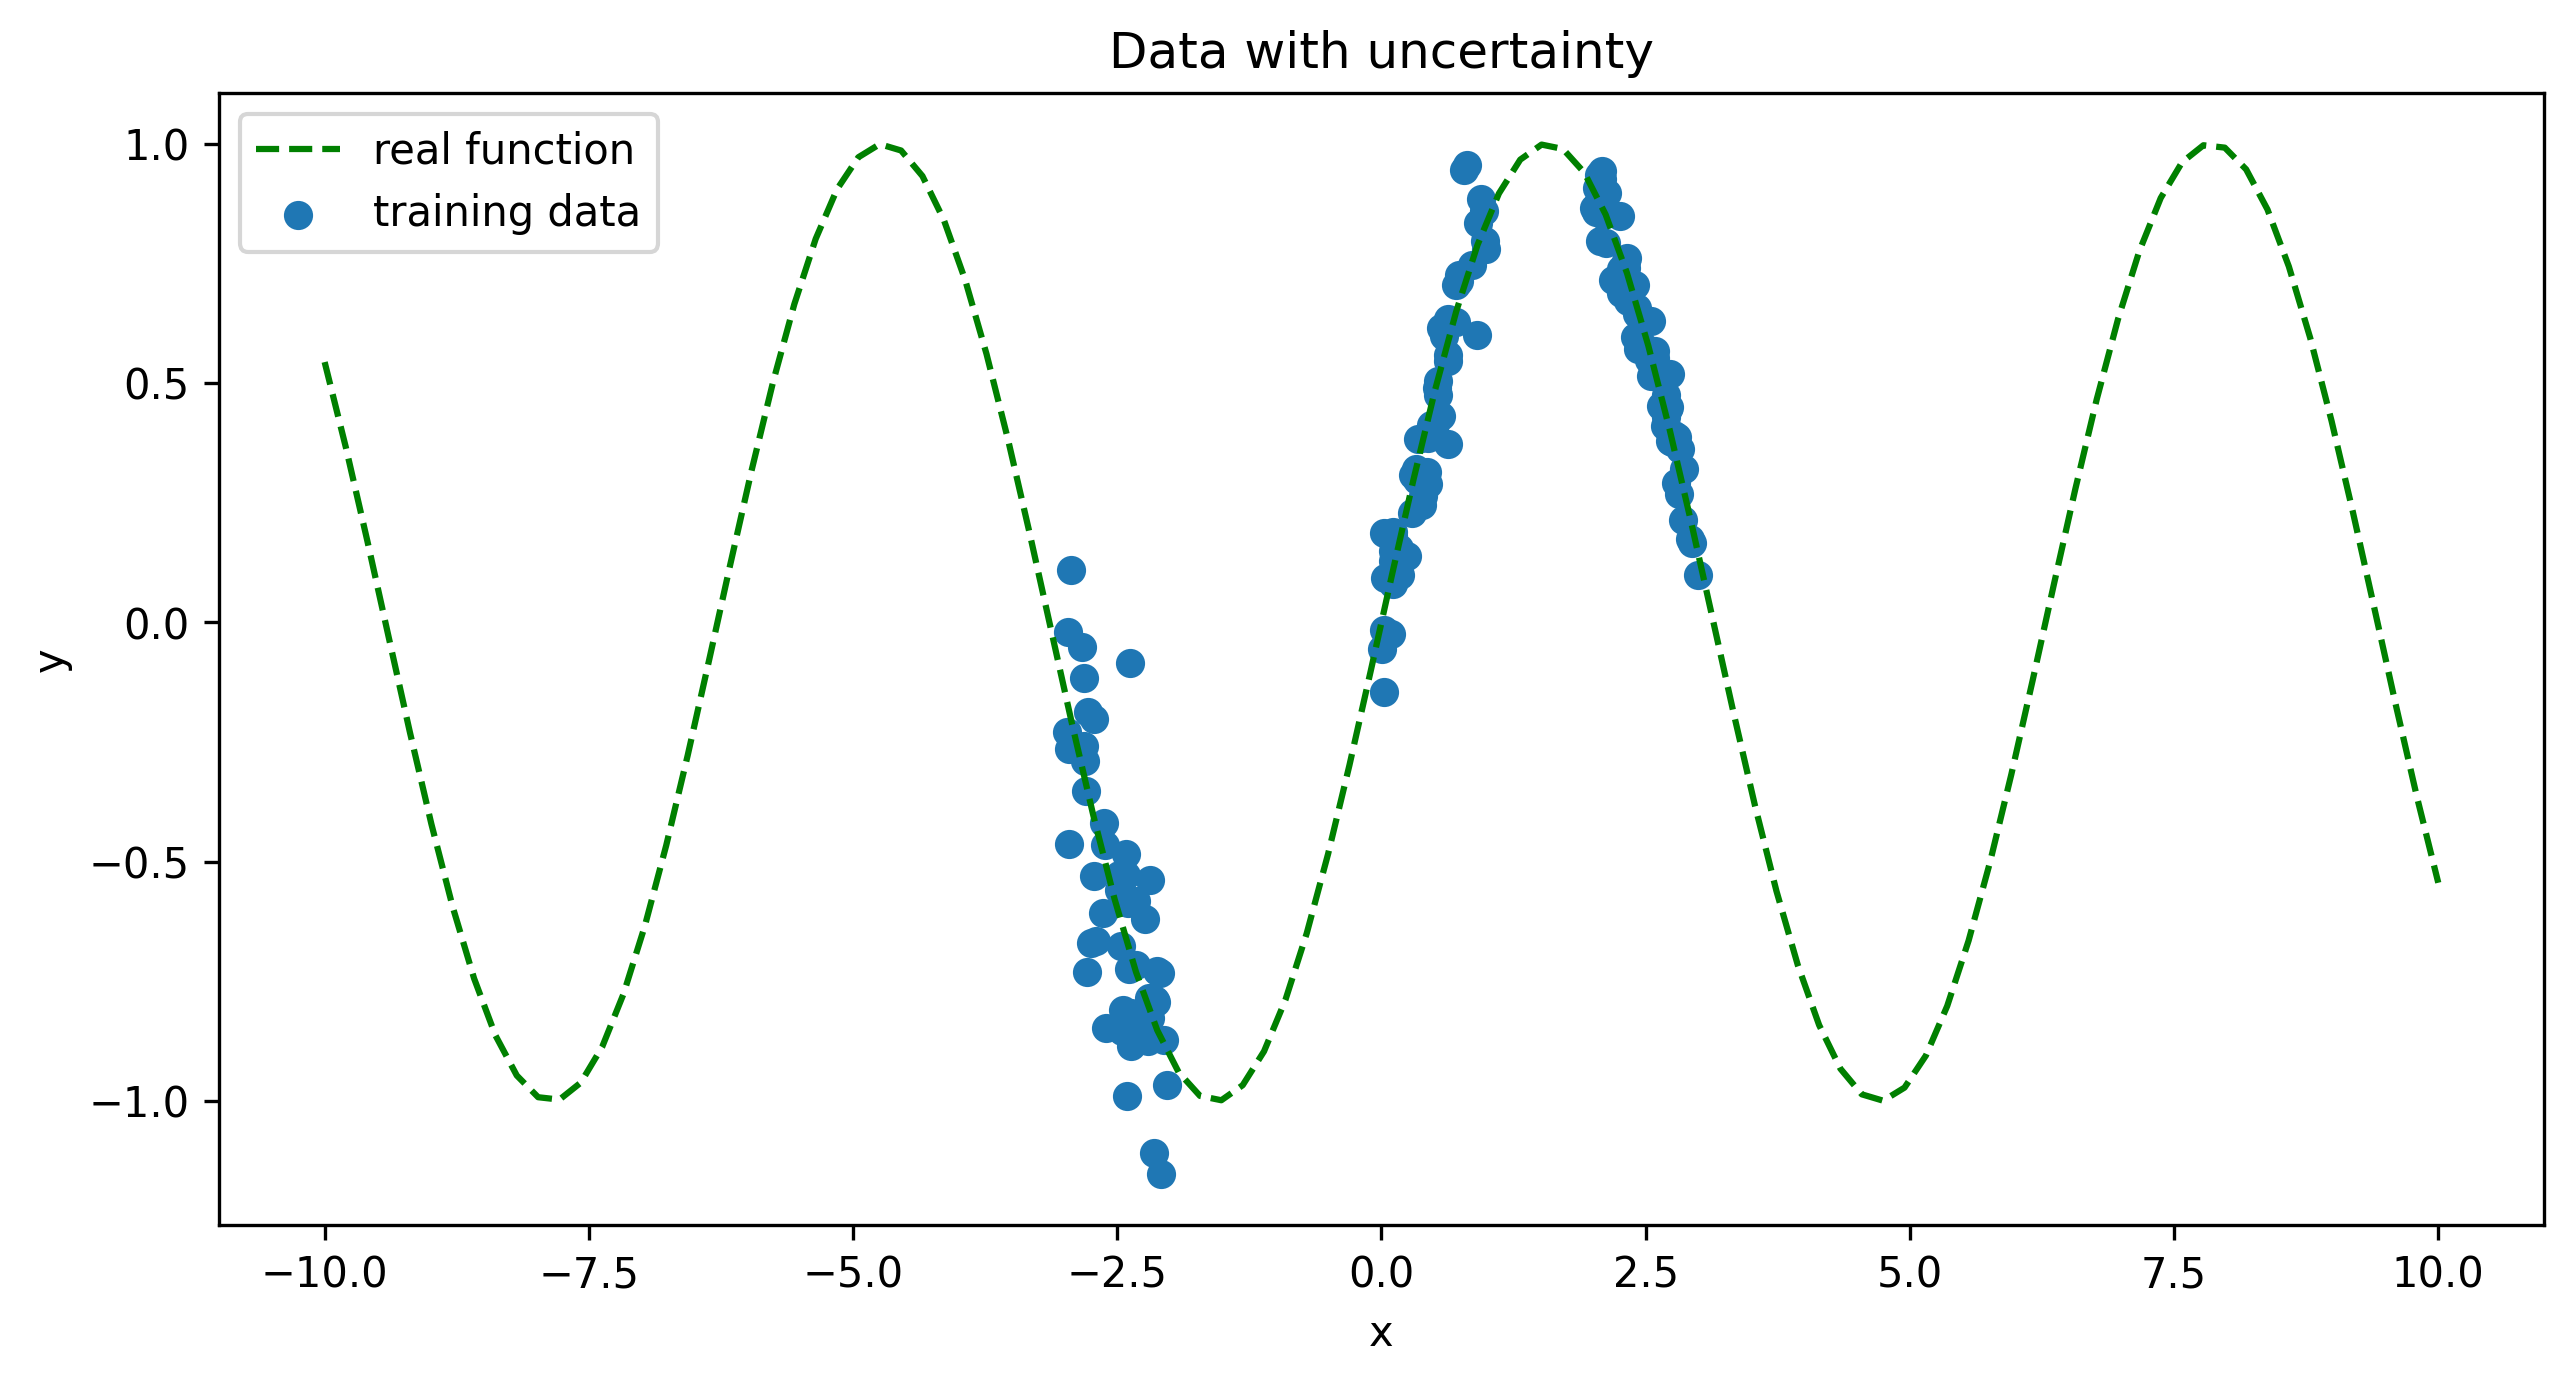

In [106]:
# sin 函数采样
x_func_poly = np.linspace(-5, 5,100)
y_func_poly = lambda x: np.sin(x)

x_train_poly = np.random.uniform(-3, -2, 50)
y_train_poly = y_func_poly(x_train_poly) + np.random.normal(scale=.2, size=x_train_poly.shape)

x_train_poly = np.concatenate([x_train_poly, np.random.uniform(0, 1, 50)])
y_train_poly = np.concatenate([y_train_poly, y_func_poly(x_train_poly[50:])
                               +np.random.normal(scale=.1, size=x_train_poly[50:].shape)])

x_train_poly = np.concatenate([x_train_poly, np.random.uniform(2, 3, 50)])
y_train_poly = np.concatenate([y_train_poly, y_func_poly(x_train_poly[100:])
                               +np.random.normal(scale=.05, size=x_train_poly[100:].shape)])

x_test_poly = np.linspace(-10, 10,100)
y_test_poly = y_func_poly(x_test_poly)

visual_dataset(x_train_poly, y_train_poly, x_test_poly, y_test_poly)

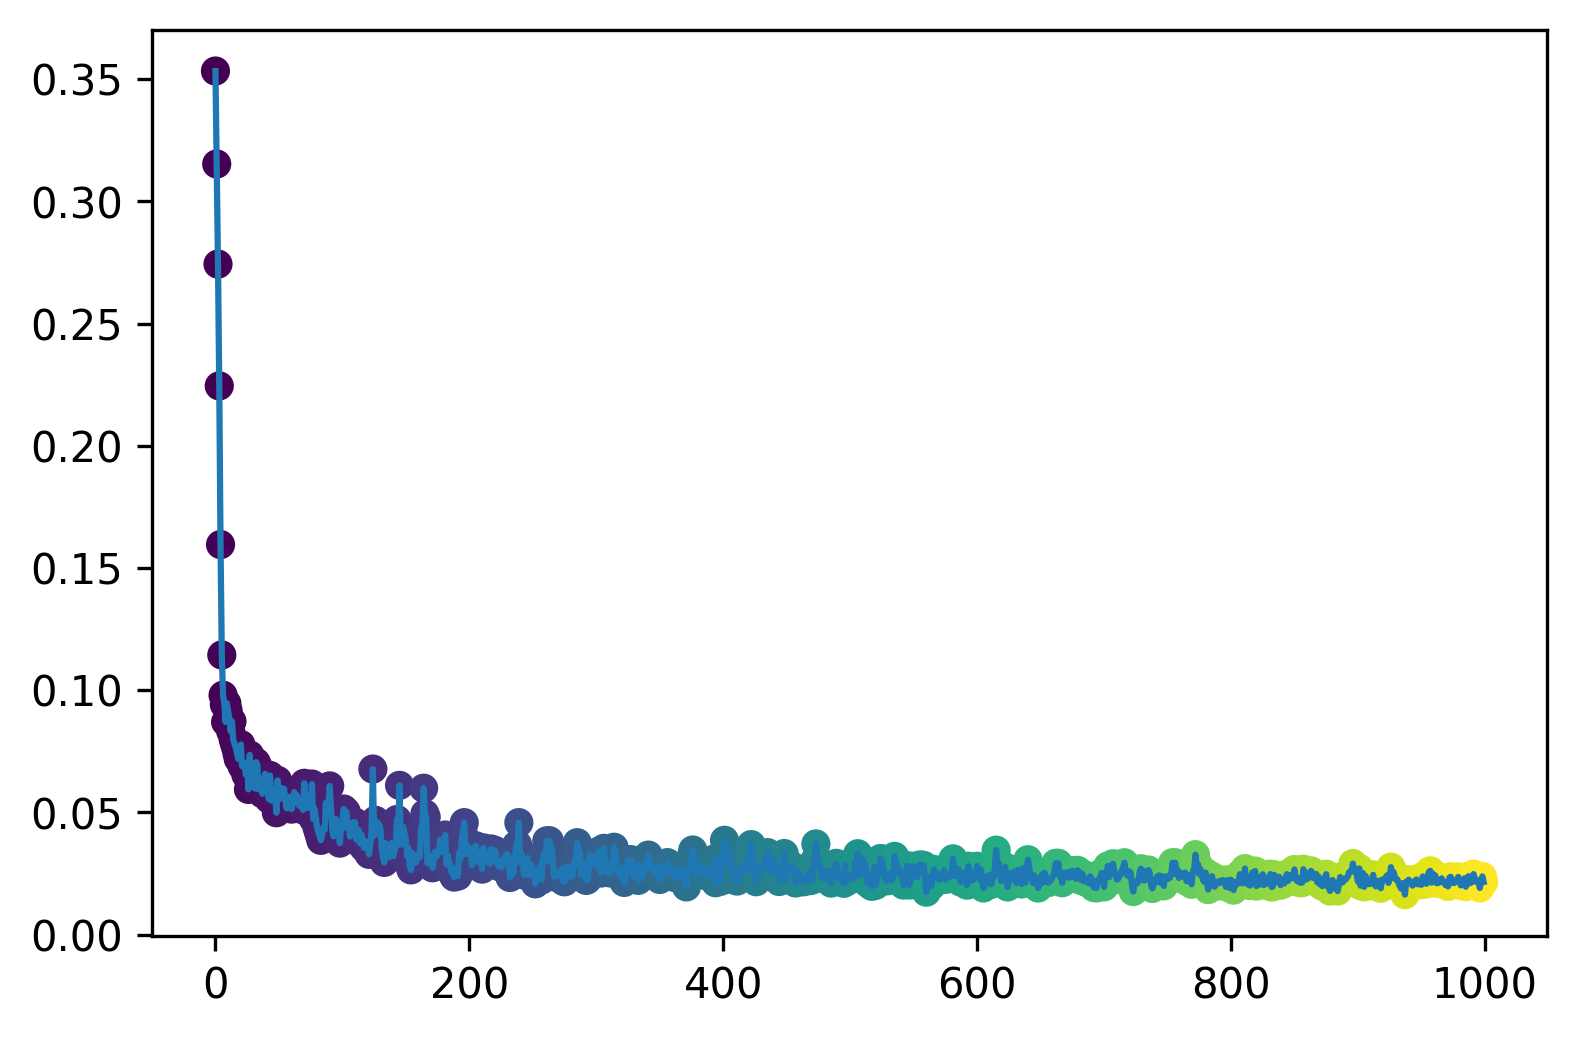

In [107]:
poly_model_with_dropout = train(Net(dropout=0.10, layers=(50, 100, 200, 200, 100, 50), Relu=True),
                                data=(x_train_poly, y_train_poly), epochs=1000)

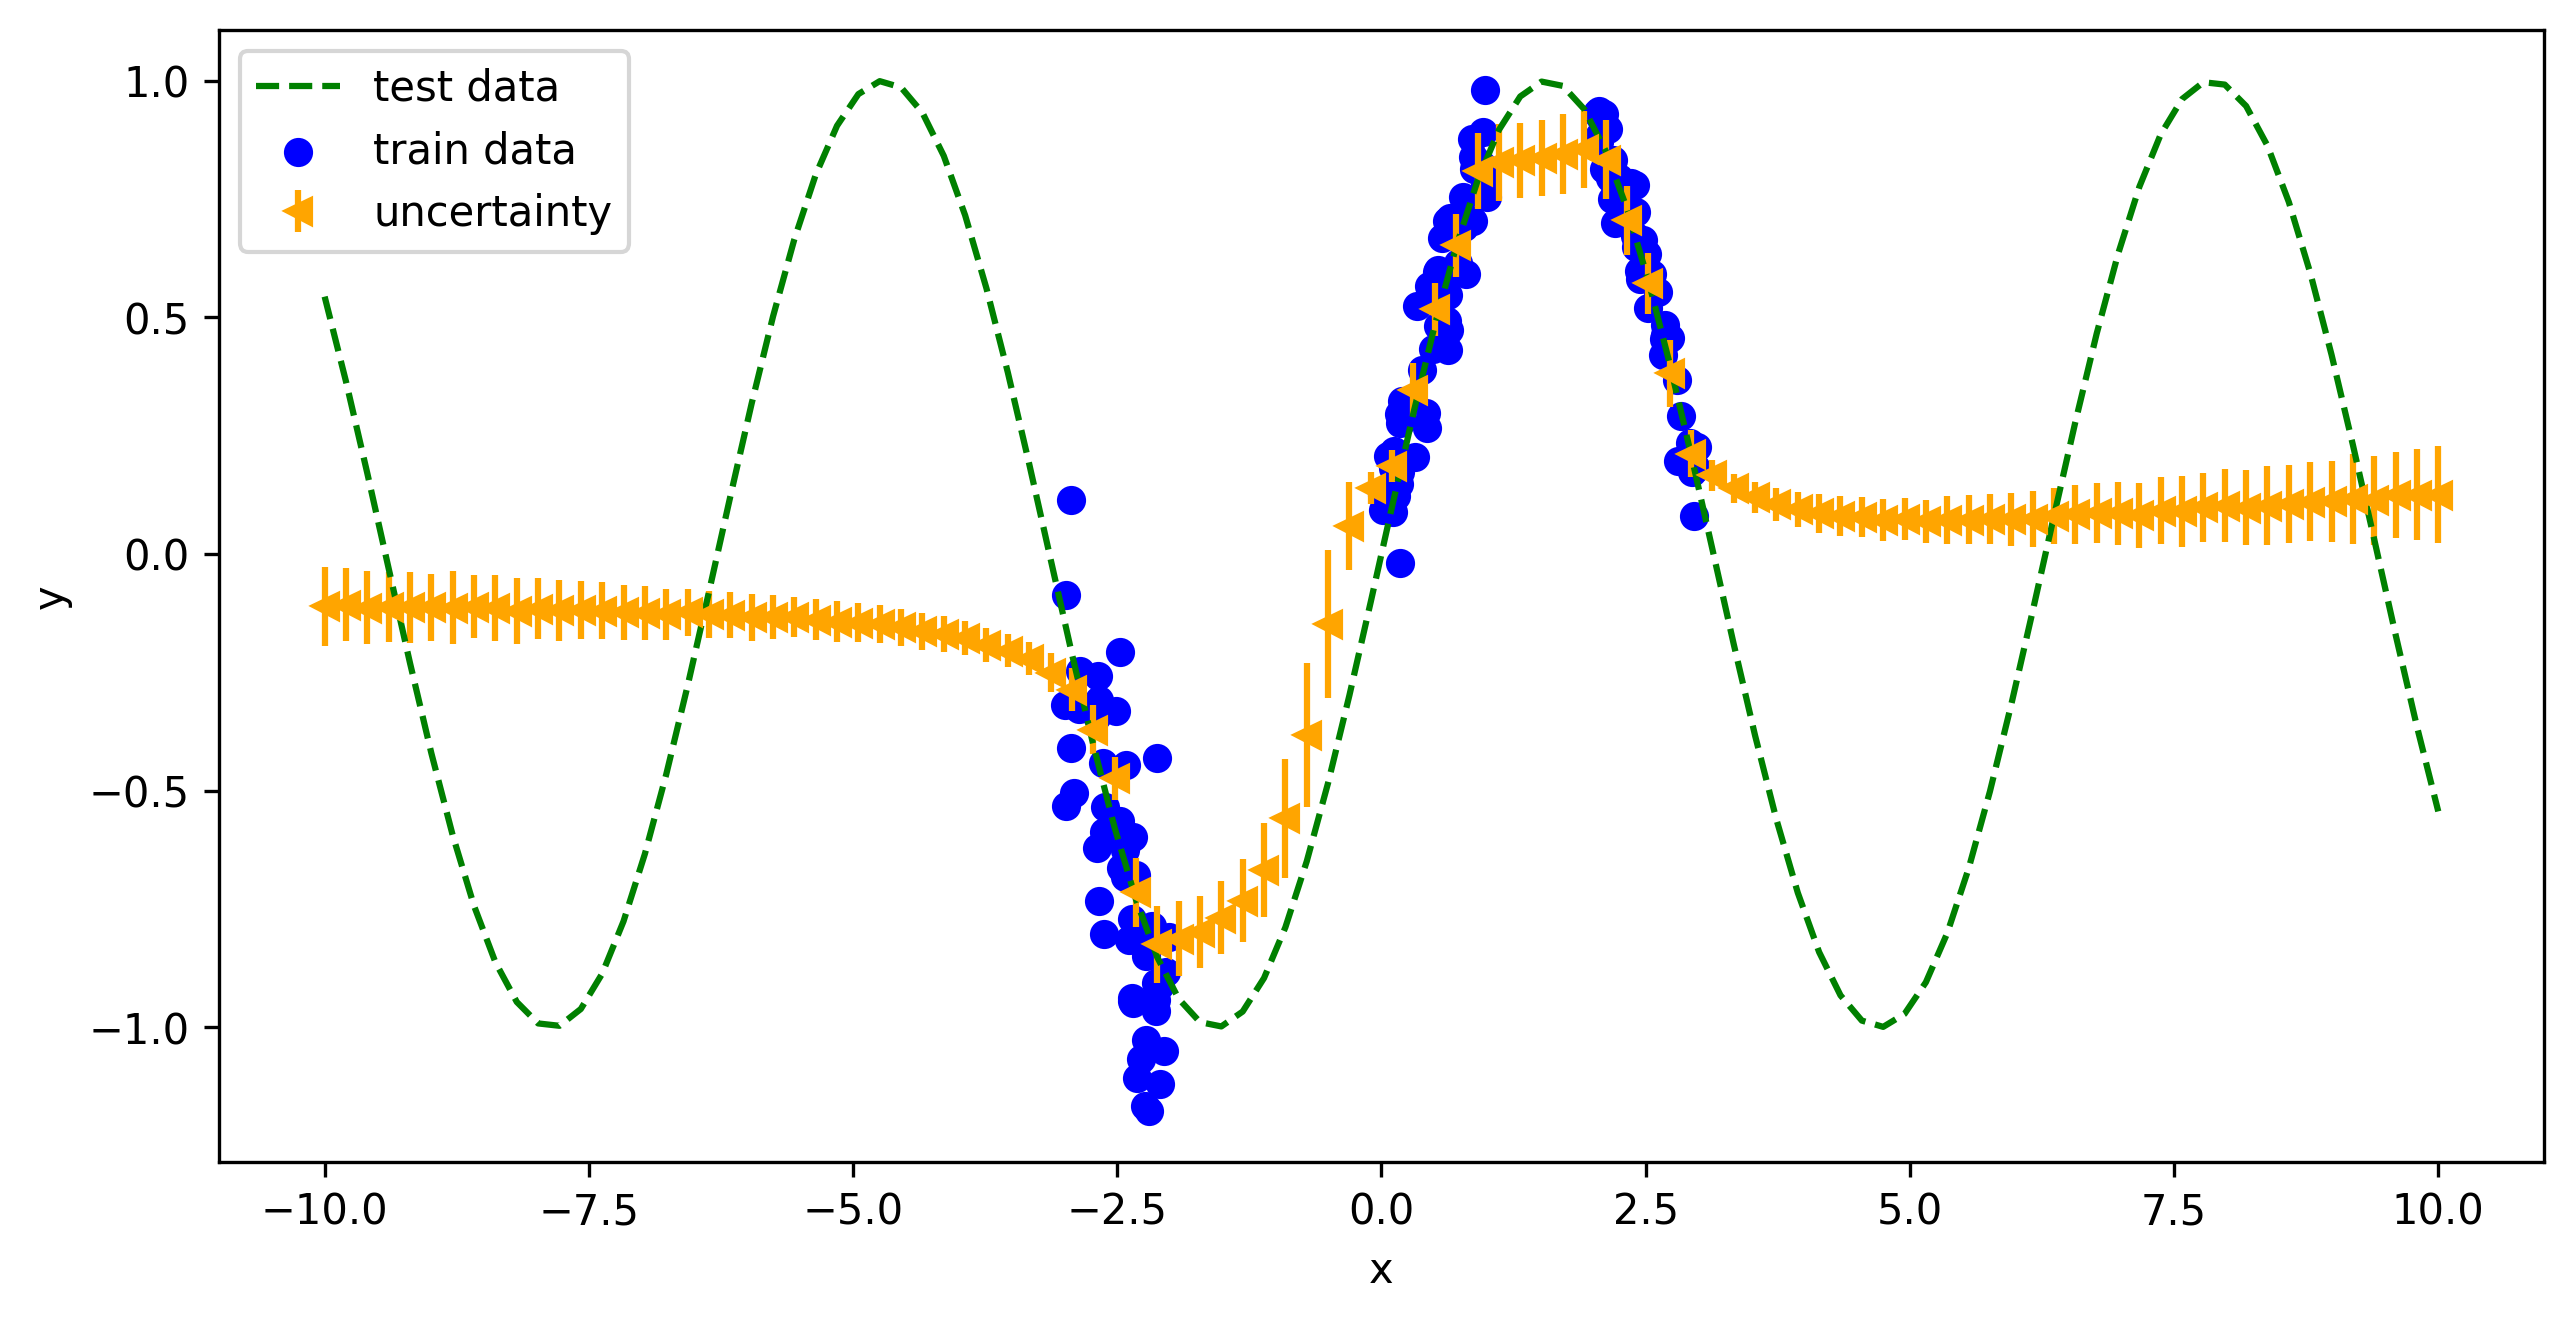

In [91]:
mean_poly, std_poly = epistemic_uncertainty(poly_model_with_dropout, (x_test_poly, y_test_poly), times=1000 )

show_uncertainty(train_data=(x_train_poly, y_train_poly), test_data=(x_test_poly, y_test_poly), 
                           test_result=(mean_poly, std_poly), function=(x_func_poly, y_func_poly))

In [109]:
class AlatoricLoss(nn.Module):
    def __init__(self):
        super(AlatoricLoss, self).__init__()
    
    def forward(self, prediction, target):
        squared_error = torch.pow(prediction[:, 0] - target[:, 0], 2)
        inverse_std = torch.exp( -prediction[:, 1] )
        mean_squared_error = torch.mean(inverse_std * squared_error)

        regression = torch.mean(prediction[:, 1])
        # 问题：这个 0.5 在这里有没有用？
        return 0.5 * (regression + mean_squared_error)


Net(
  (input_layer): Linear(in_features=1, out_features=5, bias=True)
  (hidden_layers): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): ReLU()
  )
  (output_layer): Linear(in_features=5, out_features=2, bias=True)
  (loss_function): AlatoricLoss()
)

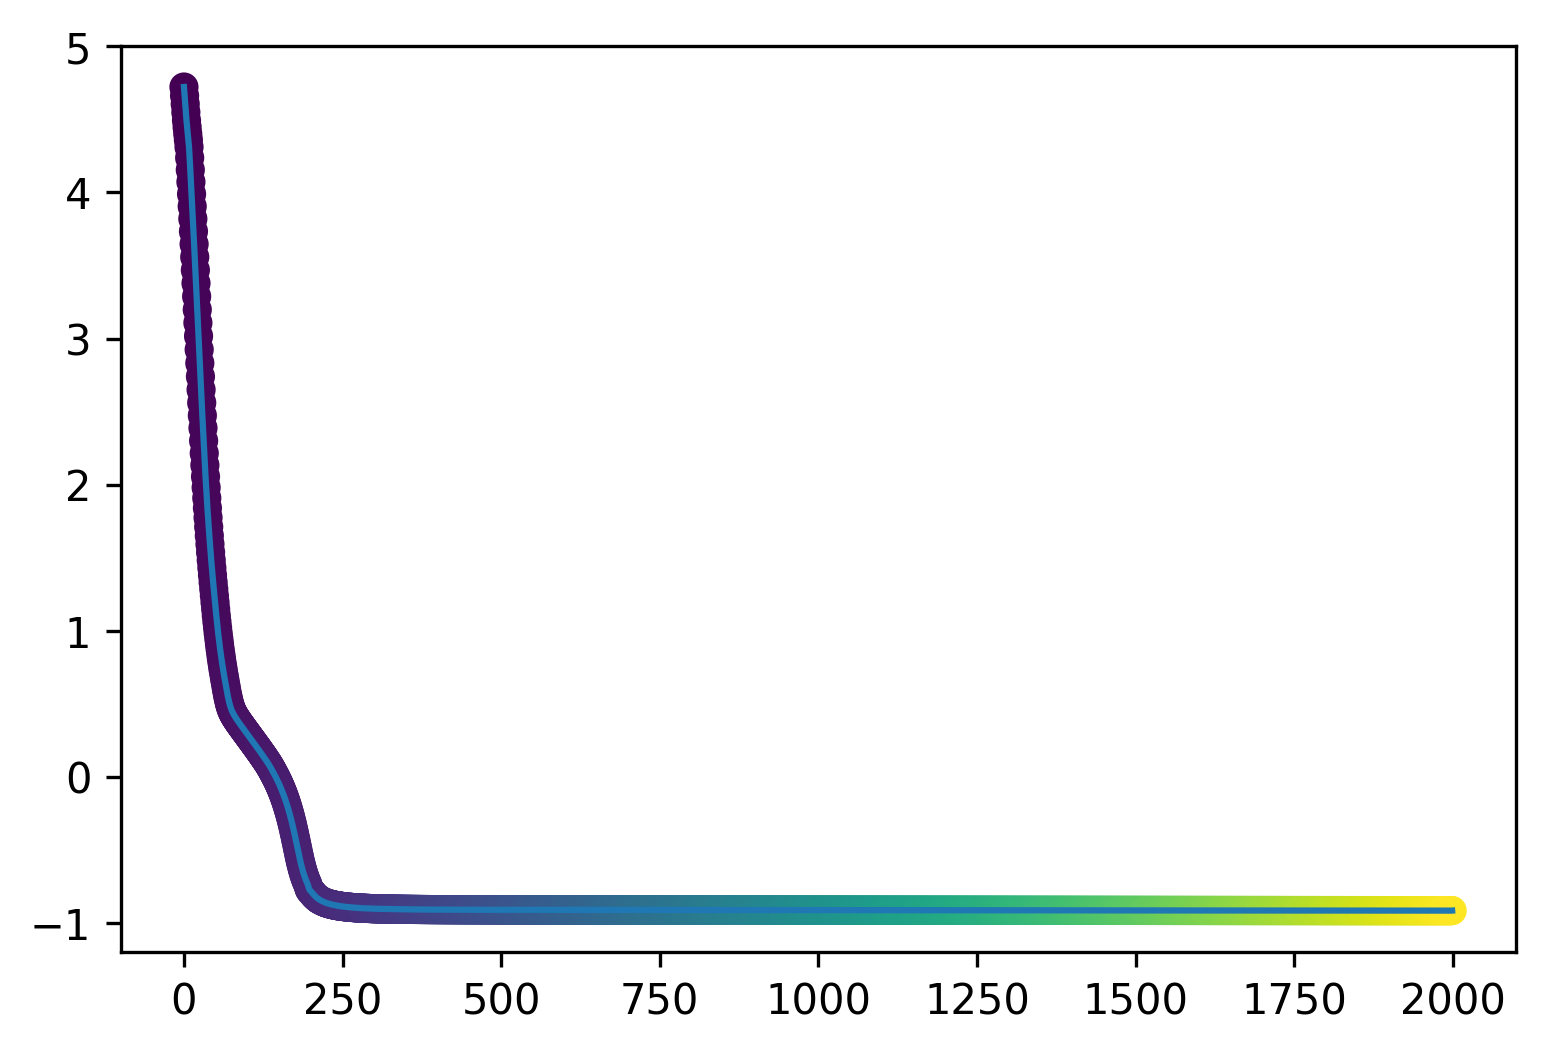

In [76]:
alatoric_loss = AlatoricLoss()
alatoric_model = Net(dropout=0, output_dim=2, Relu=True)
alatoric_model.loss_function = alatoric_loss
train(alatoric_model, data=(x_train, y_train), epochs=2000)

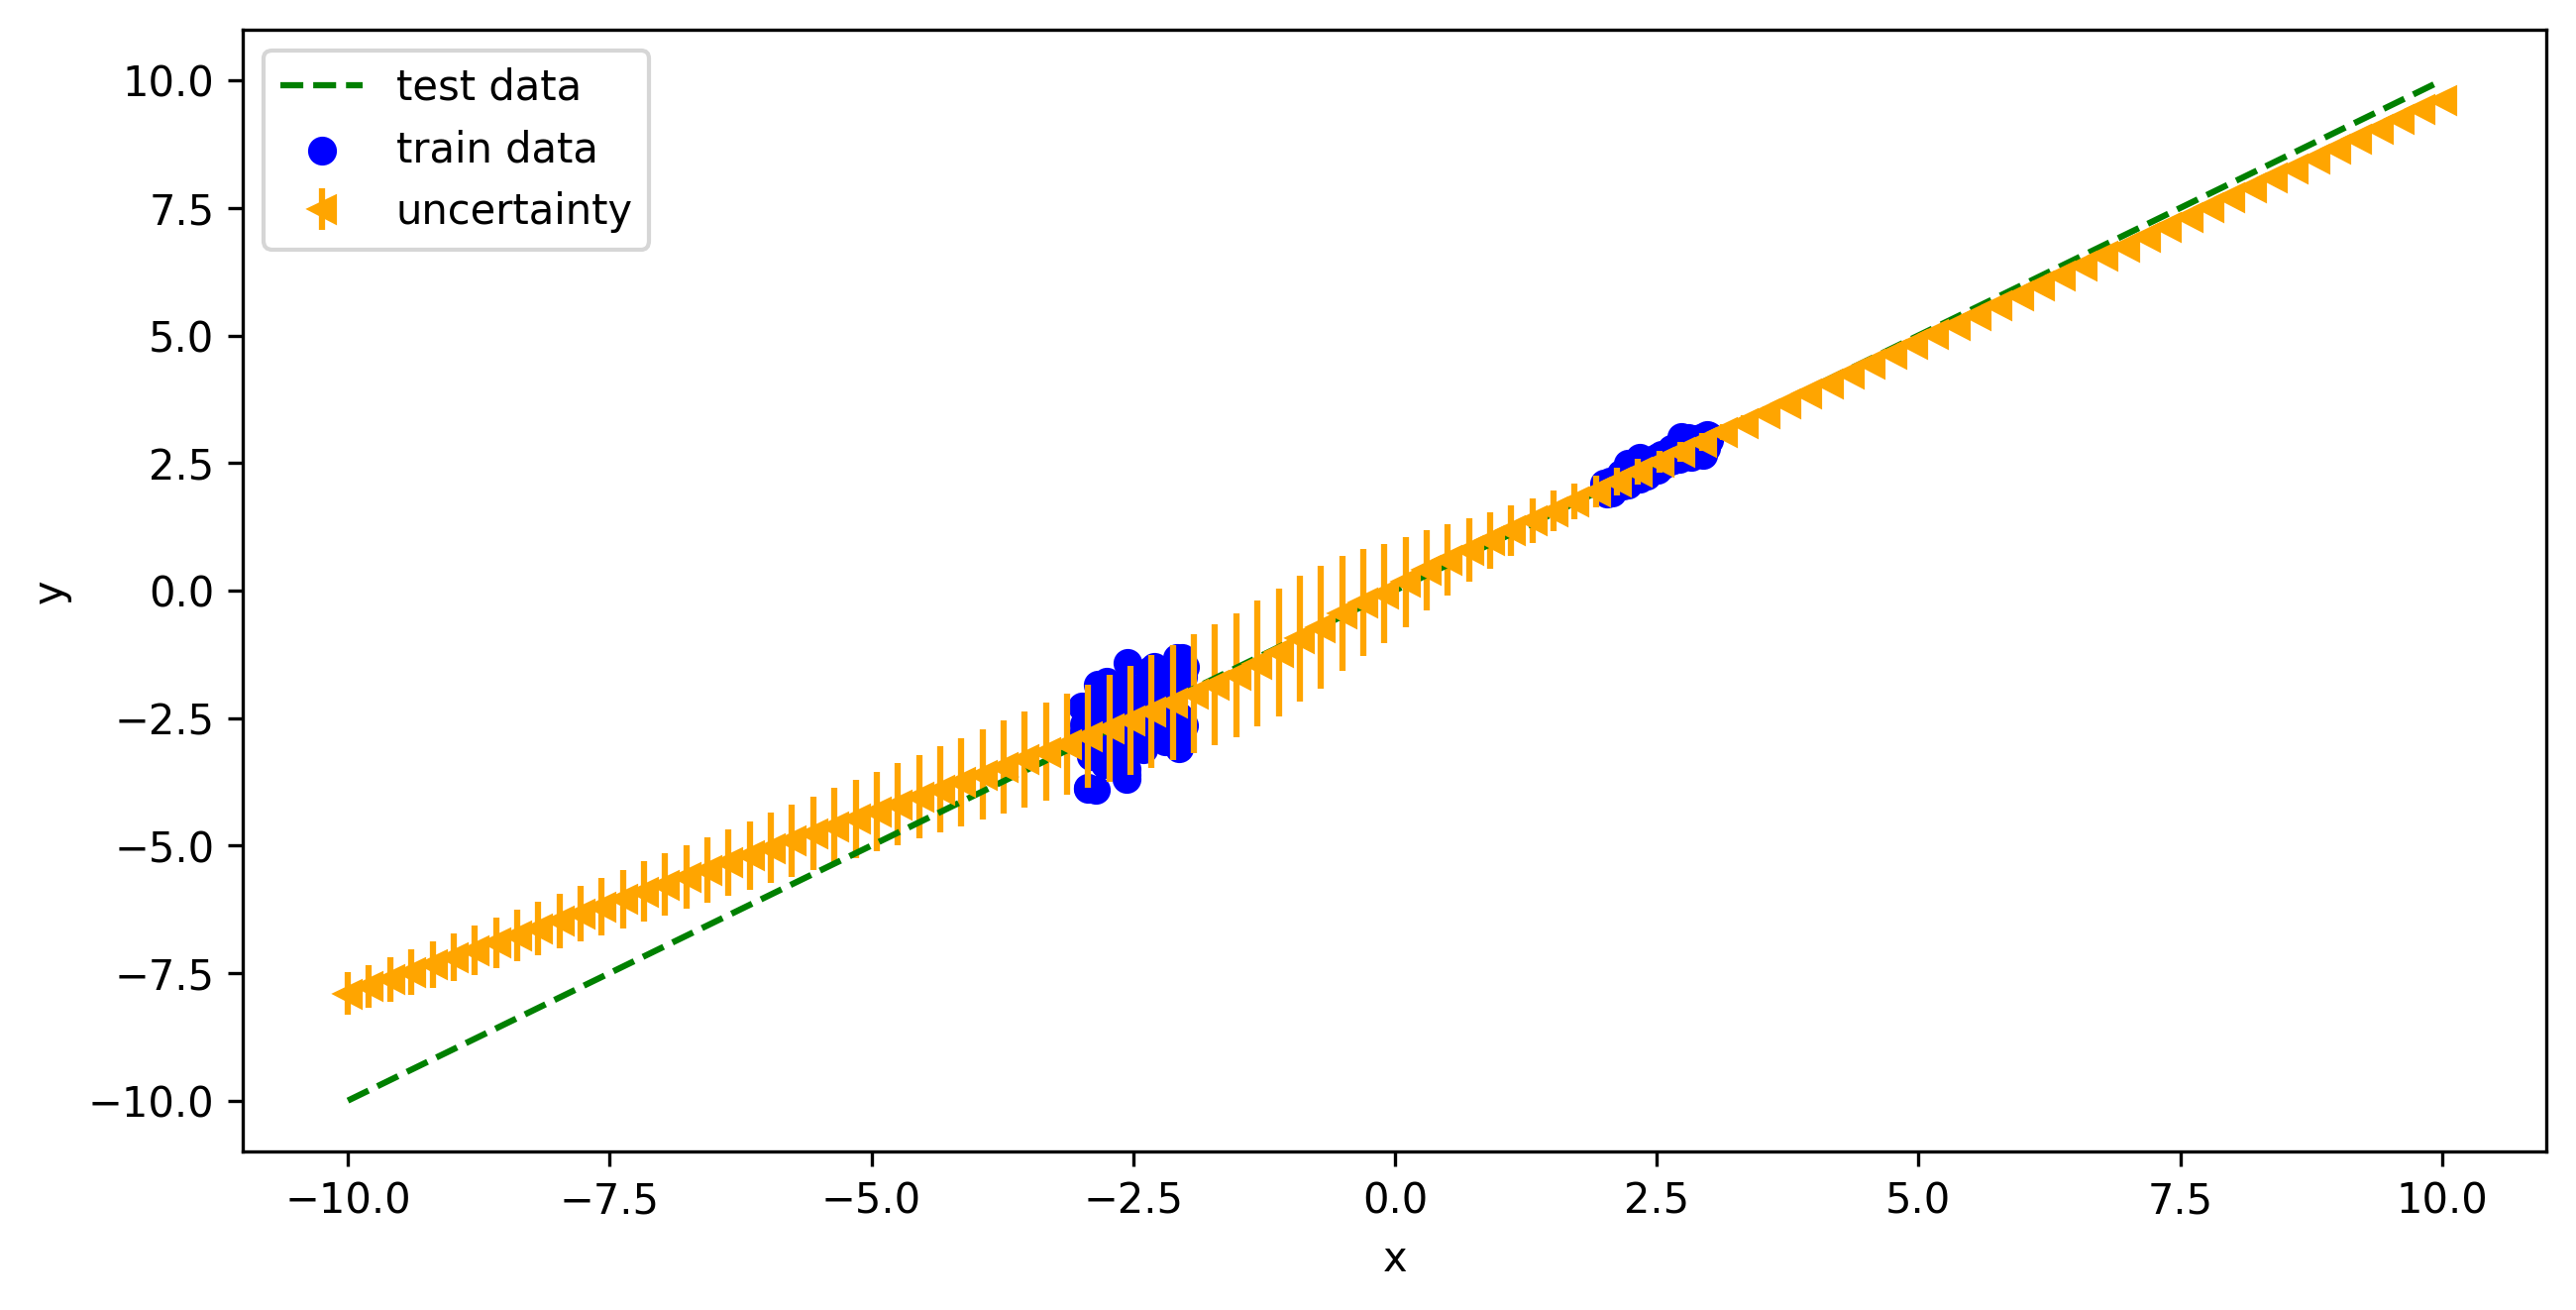

In [110]:
output = test(alatoric_model, x_test, fixed=True)
alatoric_mean = output[:, 0]
alatoric_std = 2*np.exp(0.5 * output[:, 1])
show_uncertainty((x_train, y_train), (x_test, y_test), (alatoric_mean, alatoric_std), (x_func, y_func))

Loss=||y−y^||22σ2+12logσ2
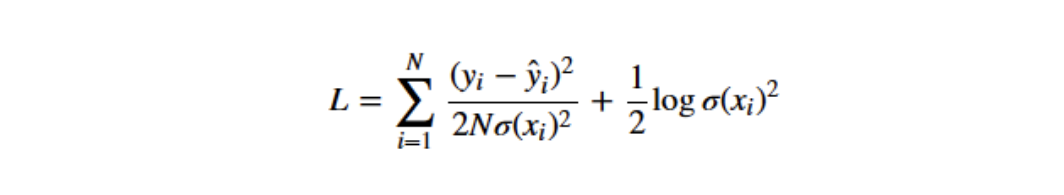